In [1]:
#libraries
import numpy as np 
import pandas as pd 
import random

# folder
import os
import glob

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow and keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

## <b>2. Loading data</b>
#### <b>There are two categories in three sets:<b>

In [2]:
train_path = 'train'
valid_path = 'val'
test_path = 'test'

In [3]:
train_datagen = ImageDataGenerator(rotation_range = 20, width_shift_range = 0.3,
                                   preprocessing_function = preprocess_input, validation_split = 0.1)

train_generator = train_datagen.flow_from_directory(train_path, target_size = (224,224), class_mode = 'sparse',
                                                    subset = 'training', shuffle = True)

val_generator = train_datagen.flow_from_directory(train_path, target_size = (224,224), class_mode = 'sparse',
                                                  subset = 'validation', shuffle = True)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_data = test_datagen.flow_from_directory(test_path, target_size = (224, 224), class_mode = 'sparse')

Found 624 images belonging to 2 classes.


## <b>5. Convolutionnal neural network<b>

In [7]:
from tensorflow.keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [8]:
base_model.trainable = True

In [9]:
global_avarage_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

fully_connected_layer = tf.keras.layers.Dense(units = 1024, activation = 'relu')(global_avarage_pooling)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)

fully_connected_layer = tf.keras.layers.Dense(units = 1024, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)

prediction_layer = tf.keras.layers.Dense(units = 2, activation = 'softmax')(fully_connected_layer)

In [12]:
clasifier = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)

In [13]:
clasifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [14]:
clasifier.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

In [15]:
#early stopping
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint('model/pneumonia.h5', monitor = 'val_loss', save_best_only = True,
                             mode = 'min', verbose = 1)
earlystop = EarlyStopping(monitor = 'val_loss', patience = 7, mode = 'min', verbose = 1, restore_best_weights = True,
                          min_delta = 0.001)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.003, patience = 3, verbose = 1, mode = 'min',
                              min_delta = 0.0001)
callback = [checkpoint, reduce_lr, earlystop]

In [17]:
epochs_history = clasifier.fit(x = train_generator, validation_data = val_generator, epochs = 50, callbacks = callback,
                               batch_size = 8)

Epoch 1/50
147/147 [==============================] - 838s 6s/step - loss: 0.0875 - accuracy: 0.9674 - val_loss: 0.0539 - val_accuracy: 0.9808

Epoch 00001: val_loss improved from 0.18914 to 0.05385, saving model to model\pneumonia.h5
Epoch 2/50
147/147 [==============================] - 767s 5s/step - loss: 0.0421 - accuracy: 0.9842 - val_loss: 0.0379 - val_accuracy: 0.9885

Epoch 00002: val_loss improved from 0.05385 to 0.03792, saving model to model\pneumonia.h5
Epoch 3/50
147/147 [==============================] - 783s 5s/step - loss: 0.0441 - accuracy: 0.9836 - val_loss: 0.0693 - val_accuracy: 0.9750

Epoch 00003: val_loss did not improve from 0.03792
Epoch 4/50
147/147 [==============================] - 886s 6s/step - loss: 0.0334 - accuracy: 0.9868 - val_loss: 0.0298 - val_accuracy: 0.9885

Epoch 00004: val_loss improved from 0.03792 to 0.02984, saving model to model\pneumonia.h5
Epoch 5/50
147/147 [==============================] - 830s 6s/step - loss: 0.0223 - accuracy: 0.9917

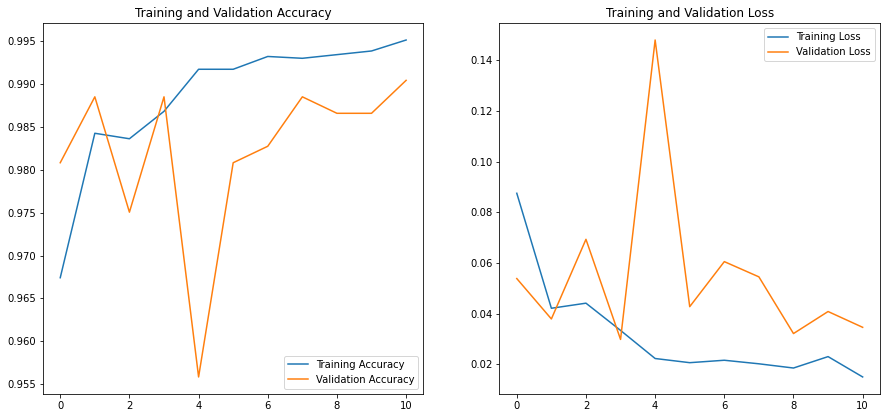

In [18]:
acc = clasifier.history.history['accuracy']
val_acc = clasifier.history.history['val_accuracy']
loss = clasifier.history.history['loss']
val_loss = clasifier.history.history['val_loss']

epochs_range = clasifier.history.epoch

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
_, accuracy = clasifier.evaluate(test_data)
print('accuracy in test_set: %.2f' %(accuracy*100),'%')

20/20 [==============================] - 13s 658ms/step - loss: 4.7067 - accuracy: 0.6250
accuracy in test_set: 62.50 %
